# Planet Score y Aerial (Glaciar)

### Nota: MODIFICADO DEL TUTORIAL

Durante este notebook exploraremos dos temáticas principales:

* Leer imágenes directamente desde los buckets de s3 para imágenes no indexadas en DCC.
* Manejar imágenes de diferentes extensiones, resoluciones, y alineaciones espaciales. Esto es sólo necesario para imágenes que no están indexadas al catálogo, como las que se describen a continuación. Si un producto está indexado en DCC, al hacer la consulta la alineación se realiza de manera automática y recomendamos hacerlo de esa manera.


## Leer imágenes desde buckets de s3

Para este ejemplo, utilizaremos imágenes desde s3 que estén vinculadas al Glaciar Grey.

Para esto necesitamos conocer las rutas específicas de cada imágen en el bucket.

Leamos el csv a continuación para conocer las rutas de cada imagen.

In [1]:
import pandas as pd
s3_images = pd.read_csv('s3_imagenes_disponibles.csv')

In [2]:
s3_images.head()

sector product     scene      date type  \
0  Valparaiso   jilin  REQ_3134  20221118  mss   
1  Valparaiso   jilin  REQ_3134  20221118  mss   
2  Valparaiso   jilin  REQ_3134  20221118  mss   
3  Valparaiso   jilin  REQ_3134  20221118  pan   
4  Valparaiso   jilin  REQ_3134  20221118  pan   

                                            filename  \
0  JL1KF01A_PMS02_20221118221930_200113258_101_00...   
1  JL1KF01A_PMS01_20221118221930_200113258_101_00...   
2  JL1KF01A_PMS02_20221118221930_200113258_101_00...   
3  JL1KF01A_PMS02_20221118221930_200113258_101_00...   
4  JL1KF01A_PMS01_20221118221930_200113258_101_00...   

                                           full_path  
0  s3://easido-prod-dc-data-projects/saf/jilin/va...  
1  s3://easido-prod-dc-data-projects/saf/jilin/va...  
2  s3://easido-prod-dc-data-projects/saf/jilin/va...  
3  s3://easido-prod-dc-data-projects/saf/jilin/va...  
4  s3://easido-prod-dc-data-projects/saf/jilin/va...

La columna `full_path` tiene la información que requerimos para obtener las imagenes desde s3.
Sin embargo, aprovecharemos de filtrar el DataFrame para quedarnos con el sector, producto y tipo de nuestro interés.

Podemos observar que, en el bucket `s3://easido-prod-dc-data-projects/saf/` disponemos de imágenes `aerial` y `planet_scope` para el glaciar grey.

In [3]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

In [4]:
import datacube
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from odc.ui import DcViewer
from datacube.utils import masking
from datacube.utils.rio import configure_s3_access

configure_s3_access(aws_unsigned=False, requester_pays=True, client=client)

In [5]:
import rioxarray
from rasterio.enums import Resampling

In [6]:
from xarray.plot.utils import _rescale_imshow_rgb # usado para reemplazar xarray.plot.imshow(robust = True)
from datacube.utils.cog import write_cog


In [7]:
dc = datacube.Datacube(app='MSS and Multiplatform') 

# Planet Scope (Glacier)

In [8]:
s3_images.loc[(s3_images['sector'] == 'Glaciar Grey') & (s3_images['product'] == 'planet_scope') & (s3_images['type'] == 'mss')].head()

sector       product     scene      date type  \
135  Glaciar Grey  planet_scope  REQ_6797  20201120  mss   
136  Glaciar Grey  planet_scope  REQ_6797  20201120  mss   
137  Glaciar Grey  planet_scope  REQ_6797  20201120  mss   
138  Glaciar Grey  planet_scope  REQ_6797  20201120  mss   
145  Glaciar Grey  planet_scope  REQ_6797  20201120  mss   

                  filename                                          full_path  
135    composite_green.tif  s3://easido-prod-dc-data-projects/saf/planet_s...  
136      composite_nir.tif  s3://easido-prod-dc-data-projects/saf/planet_s...  
137  composite_coastal.tif  s3://easido-prod-dc-data-projects/saf/planet_s...  
138      composite_red.tif  s3://easido-prod-dc-data-projects/saf/planet_s...  
145   composite_green1.tif  s3://easido-prod-dc-data-projects/saf/planet_s...

De la misma forma, para `planet_scope` de tipo `mss` existen 4 escenas distintas con múltiples bandas espectrales.

Carguemos una escena con todas sus bandas.

> Alternativamente, podemos cargar la imagen de manera lazy con Dask, como lo hace DCC pasando como argumento ´chunks´ de la misma forma que las consultas habituales que se hacen al catálogo indexado: `bandsi = [rioxarray.open_rasterio(f, chunks={'x':2048, 'y':2048}).squeeze(drop=True) for f in bands_name]`. De esta forma, podemos sacar mayor provecho a la capacida de cómputo.


### Get planet scope image

In [9]:
# scene: scene name(str), to_numpy(bool): True (return data as np cube), plot(bool): True (plot results)
def get_planet_scope(scene = 'REQ_6794', to_numpy = False, plot = False, crop = False, use_NDSI = False, use_NDSI_NVDI = False):
    idx = (s3_images['sector'] == 'Glaciar Grey') & (s3_images['product'] == 'planet_scope') & (s3_images['type'] == 'mss') & (s3_images['scene'] == scene)
    bands_name = s3_images.loc[idx]['full_path'].values

    # Las bandas para que esten ordenadas de forma asendente según su longitud de onda deben tener el siguiente orden:
    band_order = ["coastal", "blue", "green1", "green", "yellow", "red", "redegde", "nir"]
    
    bandsi = [rioxarray.open_rasterio(f, chunks={'x':2048, 'y':2048}).squeeze(drop=True) for f in bands_name]
    
    # extraemos el nombre de cada banda usando los últimos caracteres, después de "_", de la lista
    for i, im in enumerate(bandsi):
      bandsi[i].name = bands_name[i].split("_")[-1].split('.')[0]

    # Filtramos según el orden y las bandas que definimos anteriormente:
    bandsif = [f for b in band_order for f in bandsi if b == f.name]

    ds = xr.merge(bandsif)
    
    date = s3_images.loc[idx]['date'].max()
    ds = ds.expand_dims(time=pd.to_datetime([date], format = "%Y%m%d"))
    
    if (crop):
        ds = ds.where(ds_selected.y > 4345000) #

    ds.update(ds / 10000)
    
    #ds.update({'NDVI': (ds['nir'] - ds['red']) / (ds['nir'] + ds['red']),
    #        'EVI': 2.5 * ((ds['nir'] - ds['red']) / (ds['nir'] + 6 * ds['red'] - 7.5 * ds['blue'] + 1)),
    #        'NDWI': (ds['nir'] - ds['redegde']) / (ds['nir'] + ds['redegde']),
    #        #(G – SWIR1) / (G + SWIR1)
    #        'NDSI': (ds['green'] - ds['redegde']) / (ds['green'] + ds['redegde']),
    #       })


    print("Resolution: ", ds.rio.resolution())
    if (not to_numpy and plot):
        ds[["red", "green", "blue"]].squeeze().to_array().plot.imshow(robust=True, figsize=(5, 5))
    
    ## glacier mask
    if (use_NDSI_NVDI):        
        ndvi = (ds['nir'] - ds['red']) / (ds['nir'] + ds['red'])
        ndsi = (ds['green'] - ds['nir']) / (ds['green'] +ds['nir'])
        
        ndvi.attrs = ds['red'].attrs  # para mantener atributos geoespaciales
        ndsi.attrs = ds['green'].attrs  # para mantener atributos geoespaciales
        
        SELECTED = ndsi.isel(time = 0).compute()
    
    elif (use_NDSI): 
        ndsi = (ds['green'] - ds['nir']) / (ds['green'] +ds['nir'])
        ndsi.attrs = ds['green'].attrs  # para mantener atributos geoespaciales
        
        if (plot):
            ndsi.isel(time=0).plot.imshow(robust=False, figsize=(5, 5))      

        SELECTED = ndsi.isel(time = 0).compute()

        ds_mask = SELECTED.where(SELECTED > 0.01).where(SELECTED < 0.73 ).compute().to_numpy()
    
        ds_mask[ds_mask > 0.0] = 1
        
        if (plot):
            fig, ax = plt.subplots(figsize = (5,5))
            ax.imshow(ds_mask, aspect = 'auto')
            plt.show()

        # TO-DO: crop


    else:
        
        idx = (s3_images['sector'] == 'Glaciar Grey') & (s3_images['product'] == 'planet_scope') & (s3_images['type'] == 'qa') & (s3_images['scene'] == scene)
        bands_name = s3_images.loc[idx]['full_path'].values
        band_order = ["qb-shadow", "qb-confidence", "heavy", "qb-udm1", "qb-cloud", "qb-snow", "qb-clear", "light"]
        bandsi = [rioxarray.open_rasterio(f, chunks={'x':2048, 'y':2048}).squeeze(drop=True) for f in bands_name]

        # extraemos el nombre de cada banda usando los últimos caracteres, después de "_", de la lista
        for i, im in enumerate(bandsi):
            #print(bandsi[i])
            bandsi[i].name = bands_name[i].split("_")[-1].split('.')[0]
            #print(bandsi[i].name)

        # Filtramos según el orden y las bandas que definimos anteriormente:
        bandsif = [f for b in band_order for f in bandsi if b == f.name]

        ds_mask = xr.merge(bandsif)
    
        if (crop):
            ds_mask = ds_mask.where(ds_mask.y > 4345000)
    
    if (not to_numpy and plot and not use_NDSI):
        ds_mask['qb-snow'].plot.imshow(robust=False, figsize=(5, 5))
        #ds_mask['qb-cloud'].plot.imshow(robust=False, figsize=(12, 10))
    
    if (to_numpy):        
        numpy_cube = np.dstack((ds['coastal'].to_numpy()[0], # 0
                                ds['blue'].to_numpy()[0], # 1
                                ds['green1'].to_numpy()[0],  # 2
                                ds['green'].to_numpy()[0], # 3
                                ds['yellow'].to_numpy()[0], # 4
                                ds['red'].to_numpy()[0], # 5
                                ds['redegde'].to_numpy()[0], # 6
                                ds['nir'].to_numpy()[0]) # 7
                              )


        print(numpy_cube.shape)
        
        if (plot):
            fig, ax = plt.subplots(figsize = (5,5))
            RGBA_cube = np.dstack( (numpy_cube[:,:,5],numpy_cube[:,:,3],numpy_cube[:,:,1]) )
            RGBA_cube = _rescale_imshow_rgb(RGBA_cube, None, None, True) # esto solo se realiza para plot

            ax.imshow(RGBA_cube,  interpolation = 'nearest')
            plt.show()
            
        if (plot):
            fig, ax = plt.subplots(figsize = (5,5))
            ax.imshow(ds_mask['qb-snow'].to_numpy(),  interpolation = 'nearest')
            plt.show()
                    
        return numpy_cube, ds_mask['qb-snow'].to_numpy() 
    
    if (use_NDSI):
        return ds, ds_mask
    return ds,  ds_mask['qb-snow']

Resolution:  (3.0, -3.0)


/env/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/env/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/env/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/env/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


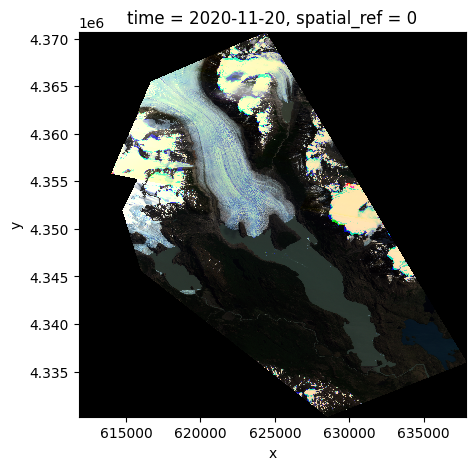

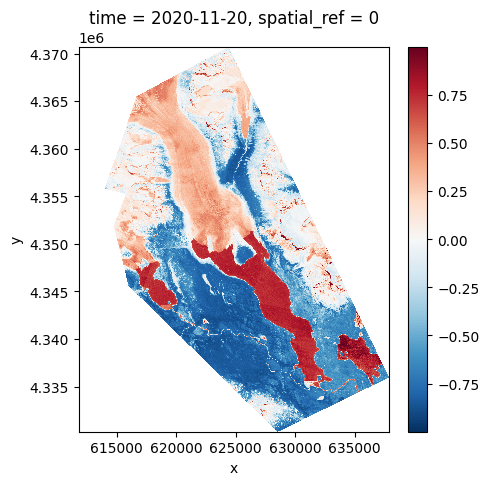

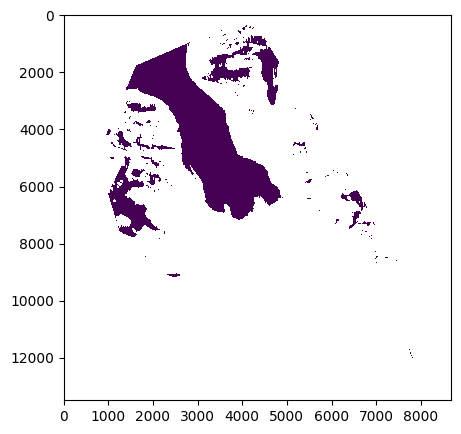

In [10]:
ds_selected, mascara = get_planet_scope(scene = 'REQ_6797', to_numpy = False, plot = True, crop = False, use_NDSI = True)

In [11]:
ds_selected

<xarray.Dataset>
Dimensions:      (time: 1, x: 8677, y: 13492)
Coordinates:
  * time         (time) datetime64[ns] 2020-11-20
  * x            (x) float64 6.118e+05 6.118e+05 ... 6.379e+05 6.379e+05
  * y            (y) float64 4.371e+06 4.371e+06 4.371e+06 ... 4.33e+06 4.33e+06
    spatial_ref  int64 0
Data variables:
    coastal      (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    blue         (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green1       (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    yellow       (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    red          (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    redegde      (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    nir          (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [12]:
# x: 8677 y: 13492 (planet scope)
# y:  x: 1371 1684 (landsat)


#x -> 8677 a 1371
#y -> 13492 a 1684

In [13]:
from scipy.signal import convolve2d

In [14]:
# downsample2d from https://gist.github.com/andrewgiessel/2955714
def downsample2d(inputArray, kernelSize): 
    """This function downsamples a 2d numpy array by convolving with a flat
    kernel and then sub-sampling the resulting array.
    A kernel size of 2 means convolution with a 2x2 array [[1, 1], [1, 1]] and
    a resulting downsampling of 2-fold.
    :param: inputArray: 2d numpy array
    :param: kernelSize: integer
    """
    average_kernel = np.ones((kernelSize,kernelSize))

    blurred_array = convolve2d(inputArray, average_kernel, mode='same')
    downsampled_array = blurred_array[::kernelSize,::kernelSize]
    return downsampled_array

def downsample2d_custom(inputArray, kernelSizeX, kernelSizeY): 
   
    average_kernel = np.ones((kernelSizeX,kernelSizeY))

    blurred_array = convolve2d(inputArray, average_kernel, mode='same')
    downsampled_array = blurred_array[::kernelSizeX,::kernelSizeY]
    print(downsampled_array.shape)
    downsampled_array = downsampled_array[:1371, :1684] # CUSTOM TO LANDSAT
    print(downsampled_array.shape)
    return downsampled_array


# Example usage:
#original_array = np.random.rand(8677, 13492)  # Sample 2D numpy array
#print(original_array.shape)

#fig, ax = plt.subplots(figsize = (5,5))
#ax.imshow(original_array)
#plt.show()

#downsampled_array = downsample2d_custom(original_array, 6, 8)  # Downsampling factor of 2
#print(downsampled_array.shape)

#fig, ax = plt.subplots(figsize = (5,5))
#ax.imshow(downsampled_array)
#plt.show()



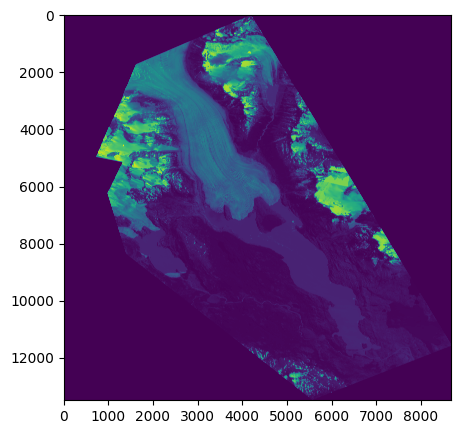

In [15]:
fig, ax = plt.subplots(figsize = (5,5))
ax.imshow(ds_selected["red"].values[0], aspect = 'auto')
plt.show()


In [16]:
#downsample2d_custom(ds_selected["red"], 8, 5)

(1687, 1736)
(1371, 1684)


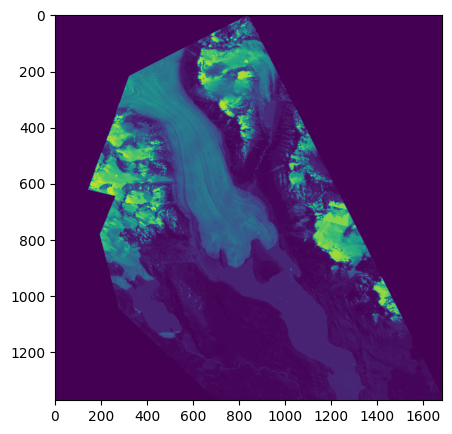

In [17]:

fig, ax = plt.subplots(figsize = (5,5))
ax.imshow(downsample2d_custom(ds_selected["red"].values[0], 8, 5), aspect = 'auto')
#ax.imshow(downsample2d_custom(ds_selected["red"].values[0], 8, 6), aspect = 'auto')
plt.show()

In [18]:
ds_selected.time.values

array(['2020-11-20T00:00:00.000000000'], dtype='datetime64[ns]')

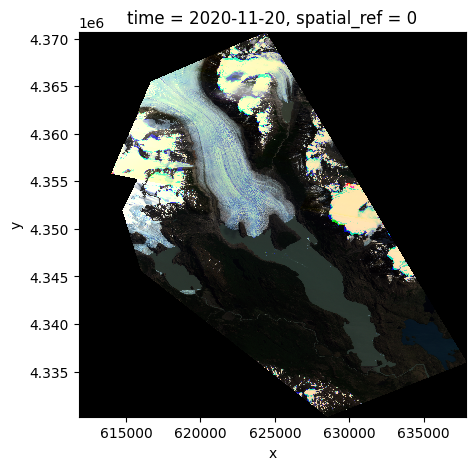

In [19]:
# dataset
ds_selected[["red", "green", "blue"]].squeeze().to_array().plot.imshow(robust=True, figsize=(5, 5))

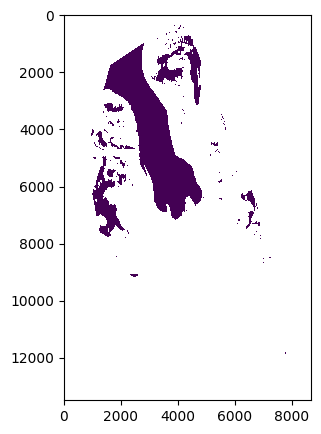

In [20]:
#mascara

fig, ax = plt.subplots(figsize = (5,5))
ax.imshow(mascara)
plt.show()

### Create tiff (Finals)

REQ_6794
Date:  20231230
Resolution:  (3.0, -3.0)


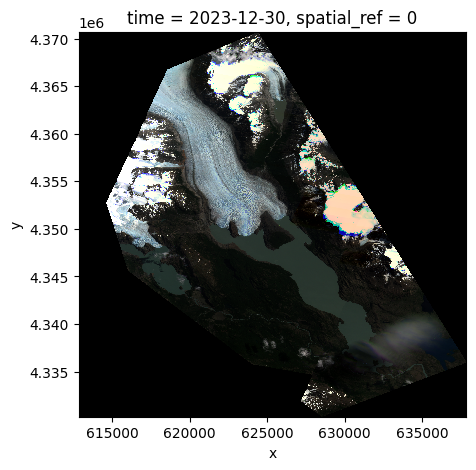

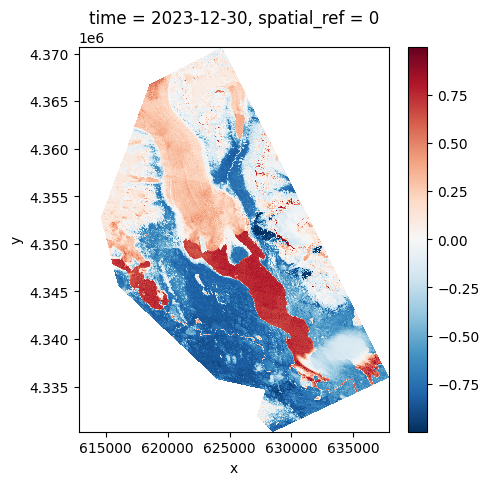

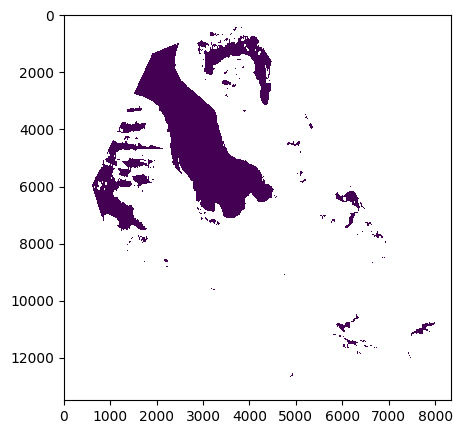


KeyboardInterrupt



In [21]:
if (True):
    for i, scene in enumerate(np.unique(s3_images[(s3_images['sector'] == 'Glaciar Grey') & (s3_images['product'] == 'planet_scope') & (s3_images['type'] == 'mss')]["scene"])):
        print(scene)
        date = s3_images[s3_images["scene"]==scene]["date"].values[0]
        print("Date: ", date)
        ds_scene, mascara = get_planet_scope(scene = scene, to_numpy = False, plot = True, crop = False, use_NDSI = True)
        ds_scene.isel(time=0).rio.to_raster(f"PlanetScope full/planetscope_{scene}.tif")
        mascara.rio.to_raster(f"PlanetScope full/planetscope_{scene}_mask.tif")

        print("---")

In [72]:
ds_selected.rio.bounds()

(611829.0, 4330251.0, 637860.0, 4370727.0)

In [73]:
ds_selected.rio.crs


CRS.from_epsg(32718)

### SRTM

In [74]:

xmin: -73.4004689
ymin: -51.1682292

xmax: -73.0437046
ymax: -50.79878

In [75]:

querySRTM = {
    "product": "srtm",
    "y": (-51.1682292, -50.79878), # obtenidas desde el ds_selected.rio.bounds() de EPSG (32718) a lat/long.
    "x": (-73.4004689, -73.0437046), # obtenidas desde el ds_selected.rio.bounds() de EPSG (32718) a lat/long.
    #"time": ("2020-01-01", "2020-12-31"),
    "output_crs": "EPSG:32719",
    "resolution": (-30, 30),
    "dask_chunks": {"time": 1, 'x':2048, 'y':2048},
    "group_by": "solar_day"
}


In [76]:
from dea_tools.plotting import display_map, rgb

display_map(x = querySRTM['x'], y = querySRTM['y'])

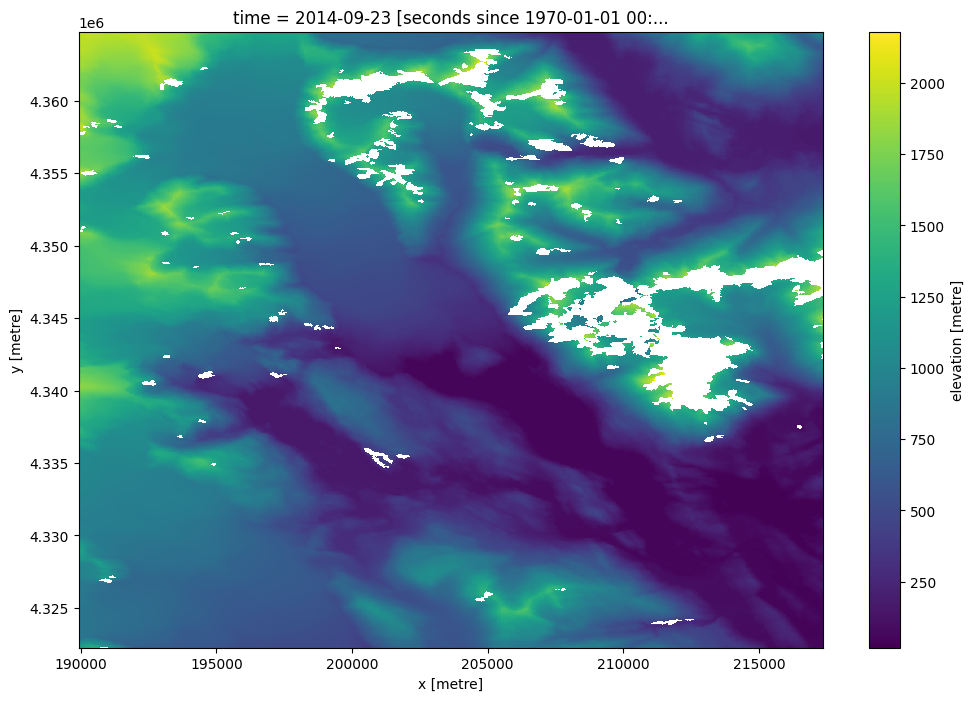

In [77]:
ds_srtm = dc.load(**querySRTM)
ds_srtm
smrt_nan_value = -32768.0
valid_elevation = ds_srtm['elevation'].where(ds_srtm['elevation'] != smrt_nan_value)
valid_elevation.isel(time=0).plot.imshow(figsize=(12, 8))

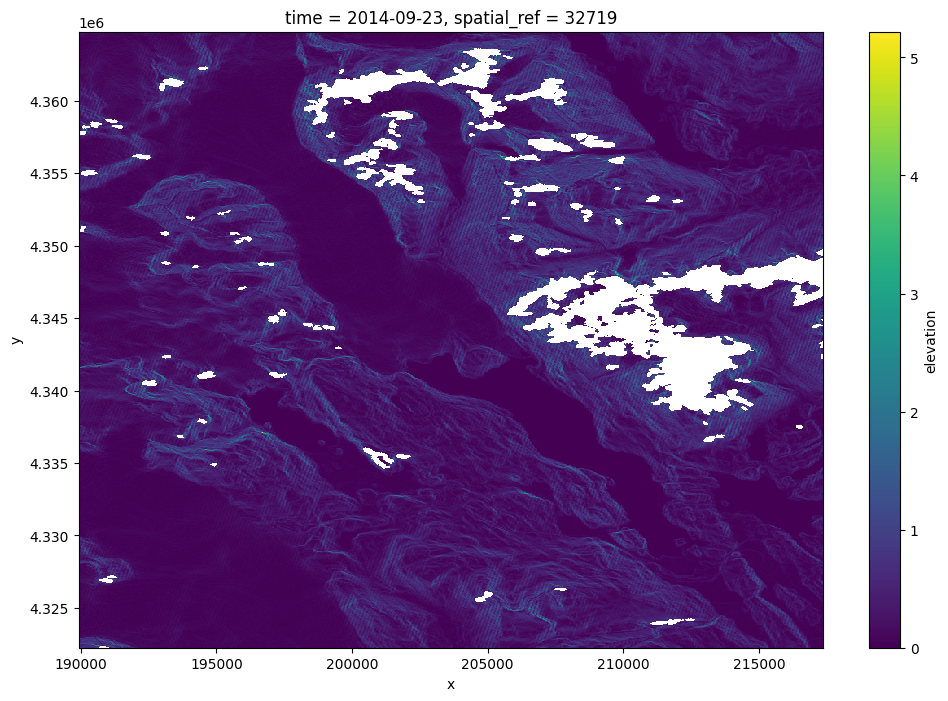

In [78]:
def magnitude(a, b):
    func = lambda x, y: np.sqrt(x**2 + y**2)
    return xr.apply_ufunc(func, a, b)

a = valid_elevation.isel(time=0).differentiate('x').compute()
b = valid_elevation.isel(time=0).differentiate('y').compute()

# Ploteamos la tasa de cambio
magnitude(a, b).plot.imshow(figsize=(12, 8))

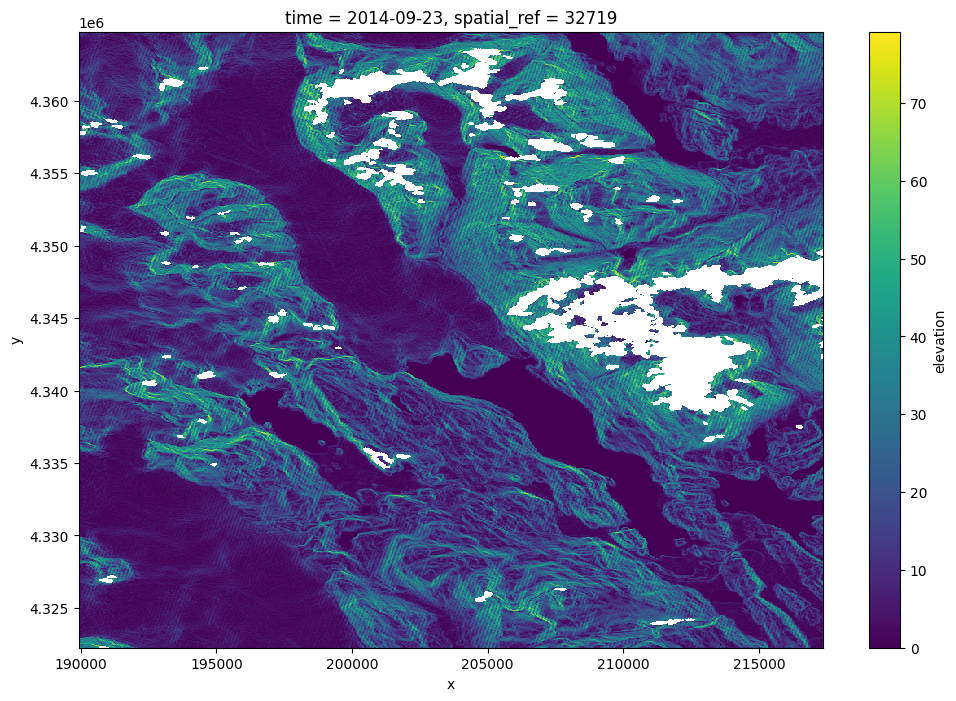

In [79]:
def degree(gradient_magnitude):
    func = lambda m: np.degrees(np.arctan(m))
    return xr.apply_ufunc(func, gradient_magnitude)

degree(magnitude(a, b)).plot.imshow(figsize=(12, 8))

In [80]:
degree(magnitude(a, b))

<xarray.DataArray 'elevation' (y: 1417, x: 914)>
array([[11.904689 , 15.89696  , 21.954996 , ..., 22.489134 , 34.017323 ,
        34.017323 ],
       [10.555381 , 11.648635 , 10.759584 , ..., 24.154045 , 35.598534 ,
        35.591187 ],
       [17.01198  , 11.461837 ,  6.8532248, ..., 35.0909   , 34.46474  ,
        34.37782  ],
       ...,
       [38.322617 , 38.756554 , 33.895367 , ...,  1.3502245,  2.1342998,
         1.9091524],
       [45.898163 , 44.61694  , 38.322617 , ...,  1.3502245,  2.698951 ,
         1.9091524],
       [48.97601  , 44.968132 , 39.066917 , ...,  2.698951 ,  4.763642 ,
         3.8140748]], dtype=float32)
Coordinates:
    time         datetime64[ns] 2014-09-23
  * y            (y) float64 4.365e+06 4.365e+06 ... 4.322e+06 4.322e+06
  * x            (x) float64 1.899e+05 1.9e+05 1.9e+05 ... 2.173e+05 2.173e+05
    spatial_ref  int32 32719

In [90]:
magnitude(a, b).rio.resolution()

(30.0, -30.0)

In [91]:
ds_selected.rio.resolution()

(3.0, -3.0)

In [82]:
MAGNITUDE = magnitude(a, b)


In [83]:
MAGNITUDE

<xarray.DataArray 'elevation' (y: 1417, x: 914)>
array([[0.21081853, 0.28480014, 0.4031129 , ..., 0.41399142, 0.6749485 ,
        0.6749485 ],
       [0.186339  , 0.20615529, 0.19002925, ..., 0.44845414, 0.715891  ,
        0.71569705],
       [0.30595934, 0.20275876, 0.12018505, ..., 0.7025746 , 0.6863753 ,
        0.68414587],
       ...,
       [0.7903937 , 0.802773  , 0.6718548 , ..., 0.02357023, 0.0372678 ,
        0.03333334],
       [1.0318538 , 0.9867174 , 0.7903937 , ..., 0.02357023, 0.04714046,
        0.03333334],
       [1.1493961 , 0.99888825, 0.8117197 , ..., 0.04714046, 0.08333334,
        0.06666667]], dtype=float32)
Coordinates:
    time         datetime64[ns] 2014-09-23
  * y            (y) float64 4.365e+06 4.365e+06 ... 4.322e+06 4.322e+06
  * x            (x) float64 1.899e+05 1.9e+05 1.9e+05 ... 2.173e+05 2.173e+05
    spatial_ref  int32 32719

In [84]:
ds_selected.rio.crs

CRS.from_epsg(32718)

In [85]:
ds_selected

<xarray.Dataset>
Dimensions:      (time: 1, x: 8677, y: 13492)
Coordinates:
  * time         (time) datetime64[ns] 2020-11-20
  * x            (x) float64 6.118e+05 6.118e+05 ... 6.379e+05 6.379e+05
  * y            (y) float64 4.371e+06 4.371e+06 4.371e+06 ... 4.33e+06 4.33e+06
    spatial_ref  int64 0
Data variables:
    coastal      (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    blue         (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green1       (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    yellow       (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    red          (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    redegde      (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    nir          (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [86]:
MAGNITUDE

<xarray.DataArray 'elevation' (y: 1417, x: 914)>
array([[0.21081853, 0.28480014, 0.4031129 , ..., 0.41399142, 0.6749485 ,
        0.6749485 ],
       [0.186339  , 0.20615529, 0.19002925, ..., 0.44845414, 0.715891  ,
        0.71569705],
       [0.30595934, 0.20275876, 0.12018505, ..., 0.7025746 , 0.6863753 ,
        0.68414587],
       ...,
       [0.7903937 , 0.802773  , 0.6718548 , ..., 0.02357023, 0.0372678 ,
        0.03333334],
       [1.0318538 , 0.9867174 , 0.7903937 , ..., 0.02357023, 0.04714046,
        0.03333334],
       [1.1493961 , 0.99888825, 0.8117197 , ..., 0.04714046, 0.08333334,
        0.06666667]], dtype=float32)
Coordinates:
    time         datetime64[ns] 2014-09-23
  * y            (y) float64 4.365e+06 4.365e+06 ... 4.322e+06 4.322e+06
  * x            (x) float64 1.899e+05 1.9e+05 1.9e+05 ... 2.173e+05 2.173e+05
    spatial_ref  int32 32719

In [87]:
ds_selected.rio.crs

CRS.from_epsg(32718)

In [89]:
# MissingCRS: CRS not found. Please set the CRS with 'rio.write_crs()'. Data variable: elevation

ps_MAGNITUDE = MAGNITUDE.rio.reproject(
    ds_selected.rio.crs,
    transform=ds_selected.rio.transform(),
    shape=ds_selected.rio.shape
)

MissingCRS: CRS not found. Please set the CRS with 'rio.write_crs()'. Data variable: elevation

In [23]:
#import dask.array as da ### NOTA: puede que haya que assignarlo como dask array, pero ahi no entendi como ponerle los chunks. 
#MAGNITUDE_time = MAGNITUDE.expand_dims(time=ds_selected["red"].time.values)
#MAGNITUDE_da = da.from_array(MAGNITUDE_time, chunks=(1, 1417, 914))

In [28]:
ds_selected = ds_selected.assign(elevation = MAGNITUDE) # .compute()?

In [29]:
ds_selected

<xarray.Dataset>
Dimensions:      (time: 1, x: 8677, y: 13492)
Coordinates:
  * time         (time) datetime64[ns] 2020-11-20
  * x            (x) float64 6.118e+05 6.118e+05 ... 6.379e+05 6.379e+05
  * y            (y) float64 4.371e+06 4.371e+06 4.371e+06 ... 4.33e+06 4.33e+06
    spatial_ref  int64 0
Data variables:
    coastal      (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    blue         (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    green1       (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    green        (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    yellow       (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    red          (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    redegde      (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    nir          (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    elevation    (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

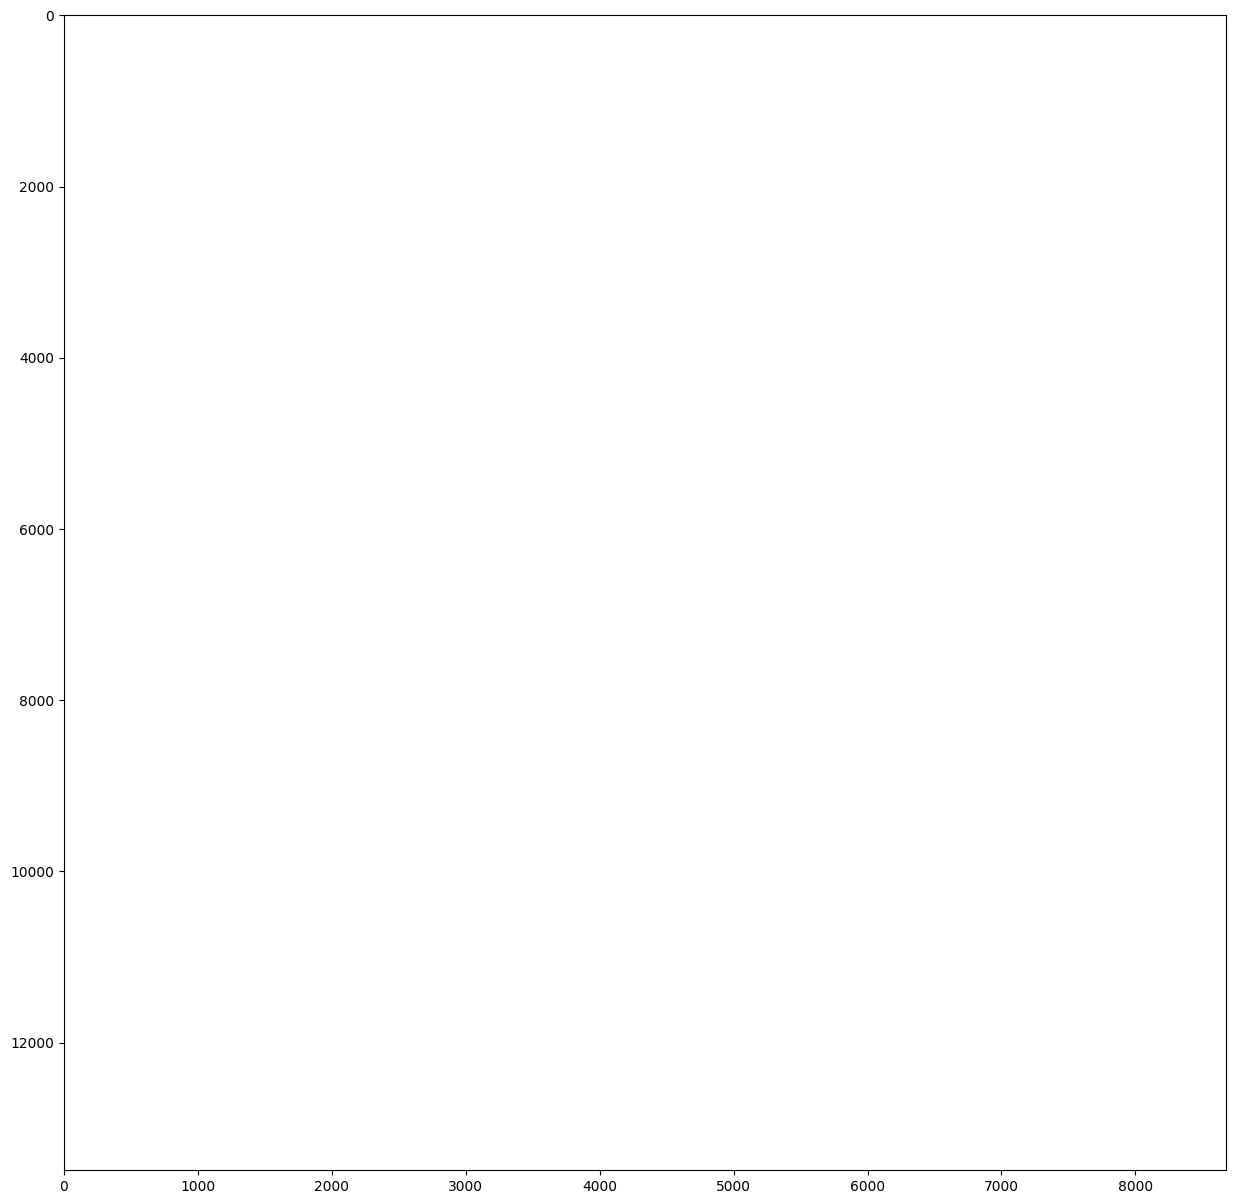

In [27]:
fig, ax = plt.subplots(figsize = (15,15))
ax.imshow(ds_selected["elevation"], aspect = 'auto')
plt.show()



#ds_selected["red"].plot.imshow(figsize=(12, 8))

In [11]:

#ndsi = (ds_selected['green'] - ds_selected['nir']) / (ds_selected['green'] +ds_selected['nir'])
#ndsi.attrs = ds_selected['green'].attrs  # para mantener atributos geoespaciales

#ndsi.isel(time=0).plot.imshow(robust=False, figsize=(12, 10))      

#SELECTED = ndsi.isel(time = 0).compute()

#GLACIER = SELECTED.where(SELECTED > 0.1).where(SELECTED < 0.73 ).compute().to_numpy()

#GLACIER[GLACIER > 0.0] = 1
#fig, ax = plt.subplots(figsize = (10,10))
#ax.imshow(GLACIER, aspect = 'auto')
#plt.show()


### Create raster tif

REQ_6797
Date:  20201120
Resolution:  (3.0, -3.0)
---


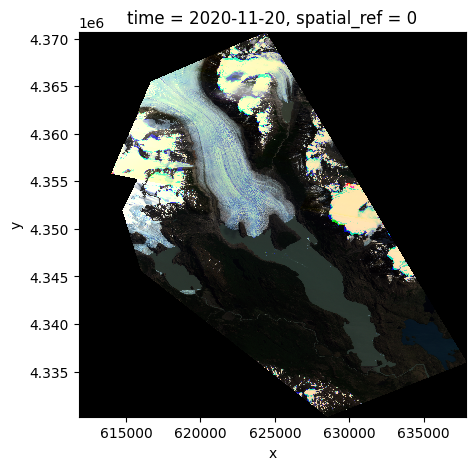

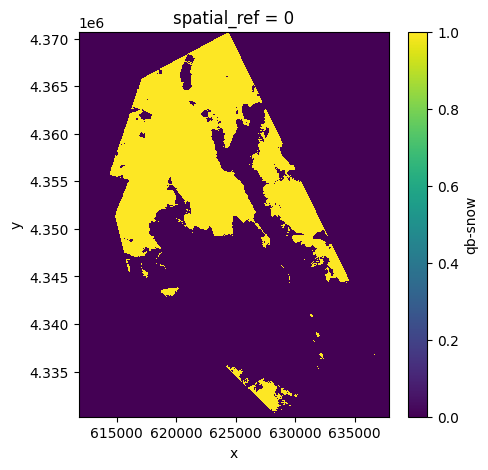

In [11]:
if (True):
    for i, scene in enumerate(np.unique(s3_images[(s3_images['sector'] == 'Glaciar Grey') & (s3_images['product'] == 'planet_scope') & (s3_images['type'] == 'mss')]["scene"])):
        if (i < 3):
            continue
        print(scene)
        date = s3_images[s3_images["scene"]==scene]["date"].values[0]
        print("Date: ", date)
        ds_scene, mascara = numpy_cube = get_planet_scope(scene = scene, to_numpy = False, plot = True, crop = False, use_NDSI = False)
        ds_scene.isel(time=0).rio.to_raster(f"planetscope_{scene}.tif")
        mascara.rio.to_raster(f"planetscope_{scene}_mask.tif")

        print("---")

REQ_6794
Date:  20231230
Resolution:  (3.0, -3.0)


/env/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/env/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/env/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/env/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


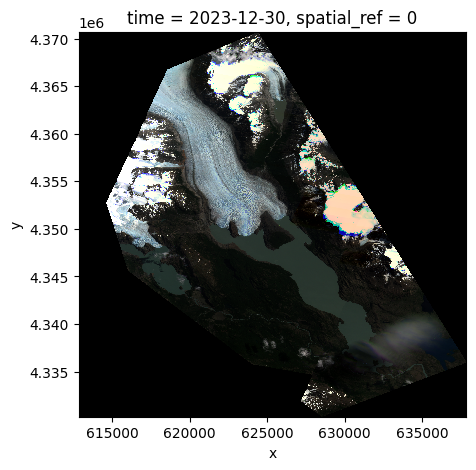

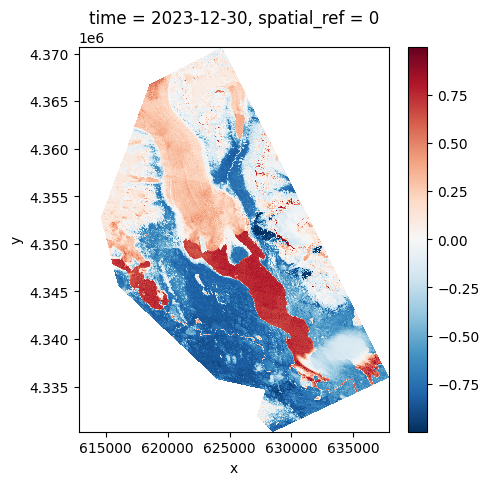

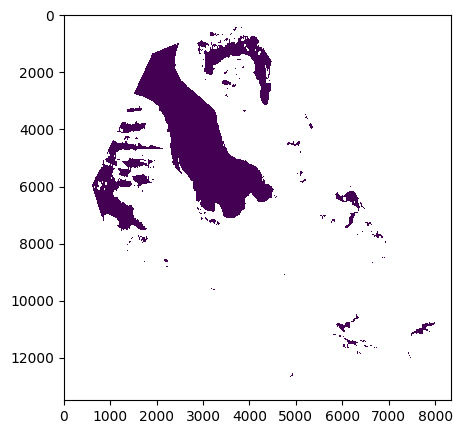

Number of 1's in mask:  19311431
---
REQ_6795
Date:  20221127
Resolution:  (3.0, -3.0)


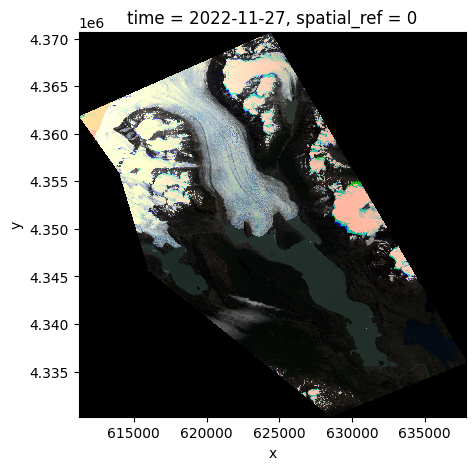

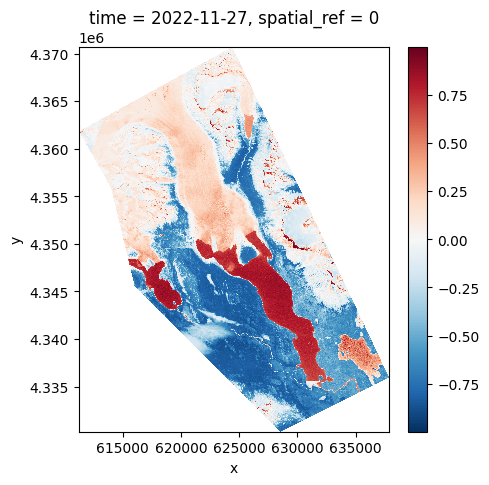

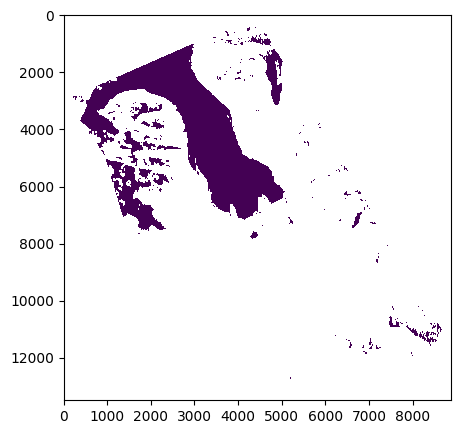

Number of 1's in mask:  21022367
---
REQ_6796
Date:  20211112
Resolution:  (3.0, -3.0)


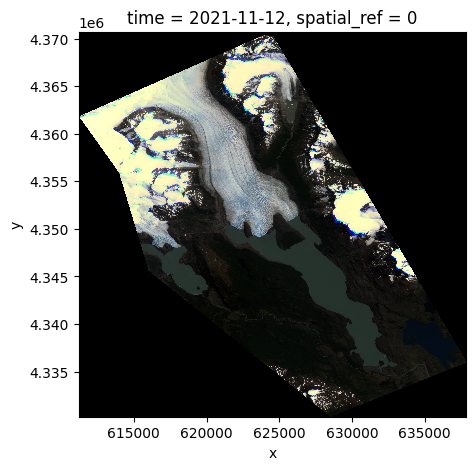

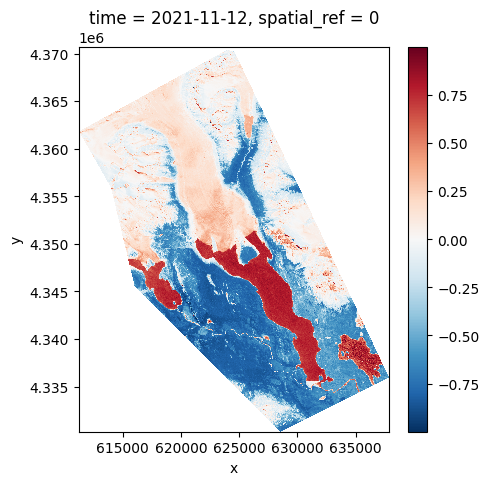

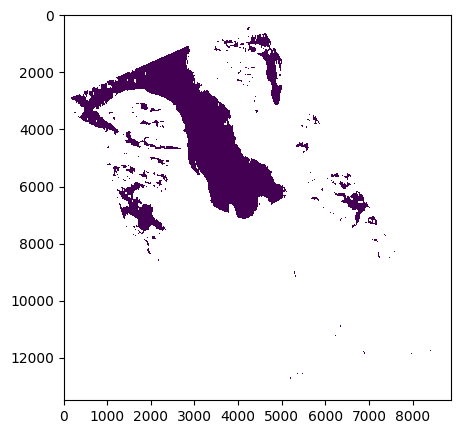

Number of 1's in mask:  21297526
---
REQ_6797
Date:  20201120
Resolution:  (3.0, -3.0)


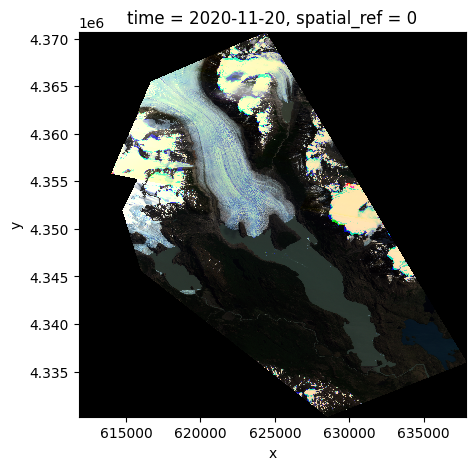

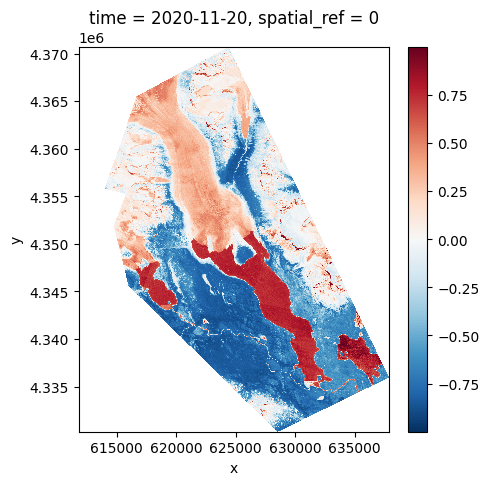

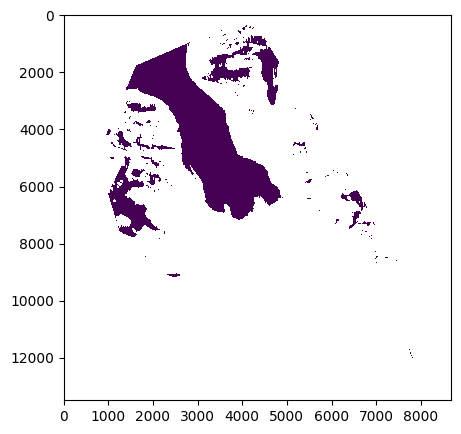

Number of 1's in mask:  19227558
---


In [10]:
number_pixel_mask_list = []
date_list = []

for scene in np.unique(s3_images[(s3_images['sector'] == 'Glaciar Grey') & (s3_images['product'] == 'planet_scope') & (s3_images['type'] == 'mss')]["scene"]):
    print(scene)
    date = s3_images[s3_images["scene"]==scene]["date"].values[0]
    print("Date: ", date)
    date_list.append(date)
    _, mascara = get_planet_scope(scene = scene, to_numpy = False, plot = True, crop = False, use_NDSI = True)
    number_pixel_mask = np.count_nonzero(mascara == 1)
    print("Number of 1's in mask: ", number_pixel_mask)
    number_pixel_mask_list.append(number_pixel_mask)
    print("---")

In [11]:
if False:
    number_pixel_mask_list = []
    date_list = []

    for scene in np.unique(s3_images[(s3_images['sector'] == 'Glaciar Grey') & (s3_images['product'] == 'planet_scope') & (s3_images['type'] == 'mss')]["scene"]):
        print(scene)
        date = s3_images[s3_images["scene"]==scene]["date"].values[0]
        print("Date: ", date)
        date_list.append(date)
        _, mascara = get_planet_scope(scene = scene, to_numpy = True, plot = True)
        number_pixel_mask = np.count_nonzero(mascara == 1)
        print("Number of 1's in mask: ", number_pixel_mask)
        number_pixel_mask_list.append(number_pixel_mask)
        print("---")

In [12]:
number_pixel_mask_list

[19311431, 21022367, 21297526, 19227558]

In [13]:
print(date_list)
date_list_formated = [f"{str(date)[6:8]}/{str(date)[4:6]}/{str(date)[:4]}" for date in date_list]

date_list_formated.reverse()
number_pixel_mask_list_formated = number_pixel_mask_list.copy()
number_pixel_mask_list_formated.reverse()

[20231230, 20221127, 20211112, 20201120]


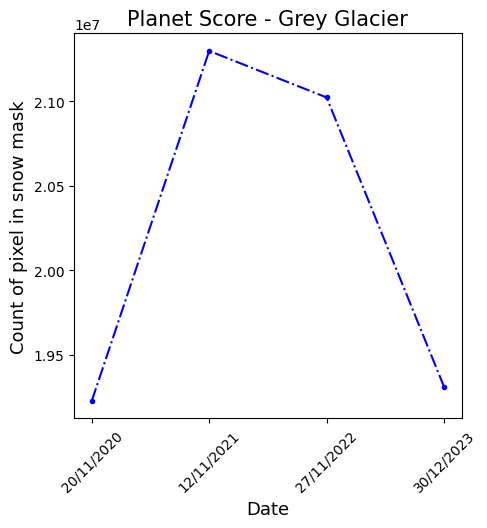

In [14]:
fig, ax = plt.subplots(figsize = (5,5))
#plt.plot(range(len(number_pixel_mask_list)), number_pixel_mask_list, 'b-')
plt.plot(date_list_formated , number_pixel_mask_list_formated, 'b.')
plt.plot(date_list_formated , number_pixel_mask_list_formated, 'b-.')
plt.xticks(rotation=45)
plt.title("Planet Score - Grey Glacier", size = 15)
plt.ylabel("Count of pixel in snow mask", size = 13)
plt.xlabel("Date", size = 13)
plt.show()

# Aerial

Notar que son scenas monobanda

In [54]:
dates_aerial = []
for s in s3_images[(s3_images['sector'] == 'Glaciar Grey') & (s3_images['product'] == 'aerial')]["scene"]:
    dates_aerial.append(s.split("_")[0])

In [55]:
s3_only_aerial = s3_images[(s3_images['sector'] == 'Glaciar Grey') & (s3_images['product'] == 'aerial')]

In [56]:
print(s3_only_aerial.shape)
print(len(dates_aerial))

s3_only_aerial["fechas"] = dates_aerial

(48, 7)
48


/tmp/ipykernel_2090/2272309678.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s3_only_aerial["fechas"] = dates_aerial


In [57]:
s3_only_aerial.head()

sector product                      scene      date      type  \
75  Glaciar Grey  aerial    19980220_12429_modified  19980220  monoband   
76  Glaciar Grey  aerial         19840330_22214_GEO  19840330  monoband   
77  Glaciar Grey  aerial  19841220_24073_modificado  19841220  monoband   
78  Glaciar Grey  aerial         19980220_12373_GEO  19980220  monoband   
79  Glaciar Grey  aerial  19850129_25841_modificado  19850129  monoband   

                         filename  \
75    19980220_12429_modified.tif   
76         19840330_22214_GEO.tif   
77  19841220_24073_modificado.tif   
78         19980220_12373_GEO.tif   
79  19850129_25841_modificado.tif   

                                            full_path    fechas  
75  s3://easido-prod-dc-data-projects/saf/aerial/G...  19980220  
76  s3://easido-prod-dc-data-projects/saf/aerial/G...  19840330  
77  s3://easido-prod-dc-data-projects/saf/aerial/G...  19841220  
78  s3://easido-prod-dc-data-projects/saf/aerial/G...  19980220  
79  s3://easido-prod-dc-data-projects/saf/aerial/G...  19850129

In [58]:
s3_only_aerial[s3_only_aerial["fechas"]== "19980220"]

sector product                    scene      date      type  \
75   Glaciar Grey  aerial  19980220_12429_modified  19980220  monoband   
78   Glaciar Grey  aerial       19980220_12373_GEO  19980220  monoband   
89   Glaciar Grey  aerial       19980220_12430_GEO  19980220  monoband   
96   Glaciar Grey  aerial       19980220_12371_GEO  19980220  monoband   
108  Glaciar Grey  aerial       19980220_12370_GEO  19980220  monoband   
113  Glaciar Grey  aerial       19980220_12431_GEO  19980220  monoband   

                        filename  \
75   19980220_12429_modified.tif   
78        19980220_12373_GEO.tif   
89        19980220_12430_GEO.tif   
96        19980220_12371_GEO.tif   
108       19980220_12370_GEO.tif   
113       19980220_12431_GEO.tif   

                                             full_path    fechas  
75   s3://easido-prod-dc-data-projects/saf/aerial/G...  19980220  
78   s3://easido-prod-dc-data-projects/saf/aerial/G...  19980220  
89   s3://easido-prod-dc-data-projects/saf/aerial/G...  19980220  
96   s3://easido-prod-dc-data-projects/saf/aerial/G...  19980220  
108  s3://easido-prod-dc-data-projects/saf/aerial/G...  19980220  
113  s3://easido-prod-dc-data-projects/saf/aerial/G...  19980220

In [59]:
def get_image_aerial(scene =  '19980220_12429_modified', plot = True):
    idx = (s3_only_aerial['sector'] == 'Glaciar Grey') & (s3_only_aerial['product'] == 'aerial') & (s3_only_aerial['type'] == 'monoband') & (s3_only_aerial['scene'] == scene)
    bands_name = s3_only_aerial.loc[idx]['full_path'].values

    #print(bands_name)
    # Las bandas para que esten ordenadas de forma asendente según su longitud de onda deben tener el siguiente orden:
    band_order = ["monoband"]
    
    bandsi = [rioxarray.open_rasterio(f, chunks={'x':2048, 'y':2048}).squeeze(drop=True) for f in bands_name]
    
    # extraemos el nombre de cada banda usando los últimos caracteres, después de "_", de la lista
    for i, im in enumerate(bandsi):
      bandsi[i].name = bands_name[i].split("_")[-1].split('.')[0]

    # Filtramos según el orden y las bandas que definimos anteriormente:
    bandsif = [f for b in band_order for f in bandsi if b == f.name]

    ds_aerial = xr.merge(bandsi)
    
    if (plot):
        fig, ax = plt.subplots(figsize = (5,5))
        ax.imshow(ds_aerial.to_array()[0], aspect = 'auto')
        plt.show()
    return ds_aerial.to_array()[0]

In [60]:
s3_only_aerial["scene"]

75       19980220_12429_modified
76            19840330_22214_GEO
77     19841220_24073_modificado
78            19980220_12373_GEO
79     19850129_25841_modificado
80     19850129_25823_modificado
81            19840330_22119_GEO
82     19841220_24060_modificado
83     19841219_23816_modificado
84            19840330_22218_GEO
85            19840330_22120_GEO
86     19850129_25821_modificado
87       19980218_11704_modified
88     19840330_22221_modificado
89            19980220_12430_GEO
90            19840330_22216_GEO
91     19850206_26266_modificado
92     19850129_25838_modificado
93     19841220_24071_modificado
94     19841219_23818_modificado
95     19841220_24062_modificado
96            19980220_12371_GEO
97            19840330_22212_GEO
98            19980218_11706_GEO
99            19840330_22122_GEO
100    19840330_22220_modificado
101           19840330_22116_GEO
102           19840330_22215_GEO
103    19840330_22219_modificado
104    19841220_24074_modificado
105    198

In [61]:
s3_only_aerial["scene"].shape

(48,)

In [62]:

scenes_with_glacier = ['19841220_24073_modificado', '19840330_22119_GEO', '19841220_24060_modificado', '19840330_22120_GEO',  
                       '19841220_24062_modificado', '19840330_22122_GEO', '19841220_24074_modificado', '19841220_24061_modificado',
                       '19980220_12370_GEO', '19980220_12370_modificado', '19840330_22121_GEO',  '19840330_22118_GEO', '19850129_25839_modificado']


In [63]:
print(len(scenes_with_glacier))

13


19841220_24073_modificado


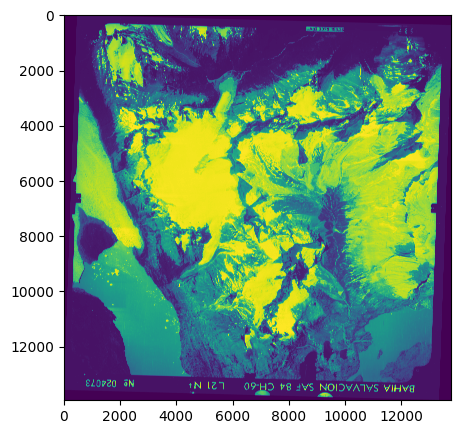

19840330_22119_GEO


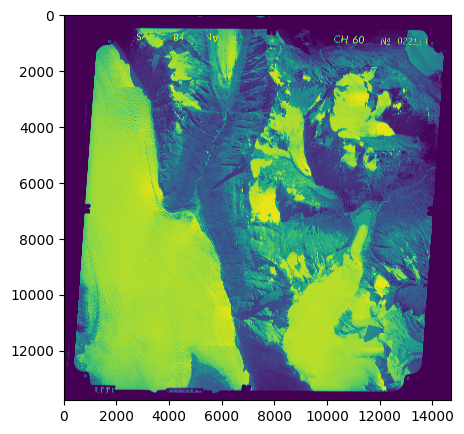

19841220_24060_modificado


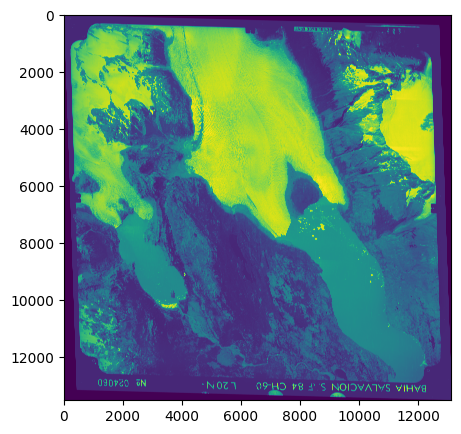

19840330_22120_GEO


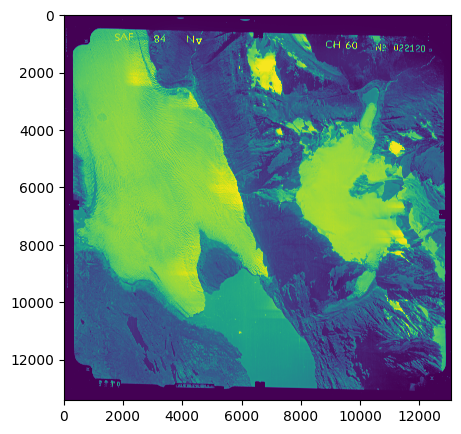

19841220_24062_modificado


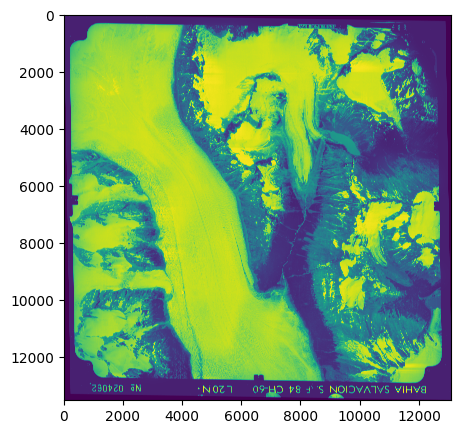

19840330_22122_GEO


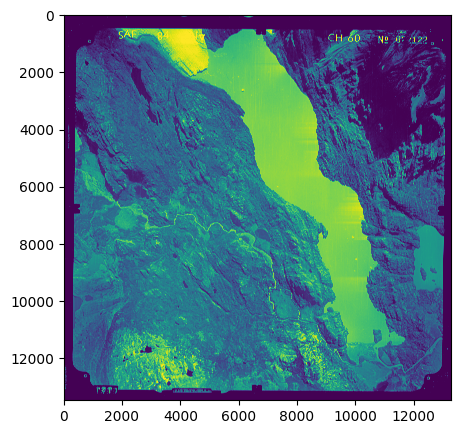

In [64]:
# con glaciar: '19841220_24073_modificado', '19840330_22119_GEO' '19841220_24060_modificado', '19840330_22120_GEO', 
# '19841220_24062_modificado', '19840330_22122_GEO', '19841220_24074_modificado', '19841220_24061_modificado', '19980220_12370_GEO'
# '19840330_22121_GEO',  '19840330_22118_GEO', '19850129_25839_modificado'


#get_image_aerial(scene =  '19980220_12429_modified')
#get_image_aerial(scene =  '19840330_22214_GEO')
#get_image_aerial(scene =  '19980220_12373_GEO')

##
#get_image_aerial(scene =  '19841220_24073_modificado')
##

#for i, scene in enumerate(s3_only_aerial["scene"]):
#    if (i < 40 or i > 48):
#        continue
#    print(scene)
#    get_image_aerial(scene =  scene)

for i, scene in enumerate(scenes_with_glacier):
    if (i > 5): # not all
        continue
    print(scene)
    get_image_aerial(scene =  scene)
    

---------------------

In [94]:
client.close()

cluster.close()